In [1]:
from google.colab import drive
drive.mount('/content/drive')
drive_folder = '/content/drive/Shareddrives/682_Drive'
# Adjust this line to be the assignment1 folder in your google drive
notebook_folder = drive_folder + '/682-Project'
%cd {notebook_folder}

Mounted at /content/drive
/content/drive/Shareddrives/682_Drive/682-Project


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install pandas torch transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [5]:
import pandas as pd
import torch
import re
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, AutoModelForSeq2SeqLM, AutoConfig

In [ ]:
# # Load dataset from CSV
# # dataset = load_dataset('train.csv')
# dataset = load_dataset('ag_news')


##Data Preparation for AG News Dataset
In this section, we will process the AG News dataset, sourced from Hugging Face's datasets library, to create an imbalanced dataset suitable for analysis. The AG News dataset contains four classes of news articles:

World (label 0)
Sports (label 1)
Business (label 2)
Sci/Tech (label 3)
Process Overview
Data Loading:
The AG News dataset will be loaded and converted into a Pandas DataFrame to enable easier manipulation and preprocessing.

Text Preprocessing:
Each article's text will be cleaned by removing special characters, extra spaces, and converting all text to lowercase for uniformity.

Class Separation and Downsampling:

We will separate the dataset by class.
Each class will be downsampled to a specific number of samples to create class imbalance:
World: 4,000 samples
Sports: 7,000 samples
Business: 3,000 samples
Sci/Tech: 2,000 samples
Dataset Reconstruction and Shuffling:
The downsampled data from all classes will be combined, and the resulting dataset will be shuffled to ensure the samples are randomized.

Class Distribution Check:
A summary of the new class distribution will be printed to confirm the imbalance.

Saving the Dataset:
The imbalanced dataset will be saved as a CSV file in Google Drive for future use in experiments, such as training baseline models or data augmentation studies.

This process allows us to simulate a real-world scenario where some classes are underrepresented

In [ ]:
# Load the AG News dataset from Hugging Face's `datasets` library
dataset = load_dataset('ag_news', split='train')

# Convert to a DataFrame for easier manipulation
data = dataset.to_pandas()

# Text cleaning function
def clean_text(text):
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)  # Remove non-alphanumeric characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    return text.strip().lower()  # Convert to lowercase and remove trailing spaces

# Apply cleaning to the dataset
data['text'] = data['text'].apply(clean_text)

# Separate classes
world_data = data[data['label'] == 0]      # Class 0: World
sports_data = data[data['label'] == 1]     # Class 1: Sports
business_data = data[data['label'] == 2]   # Class 2: Business
sci_tech_data = data[data['label'] == 3]   # Class 3: Sci/Tech

# Downsample each class to different levels to create imbalance
world_data_downsampled = world_data.sample(n=500, random_state=42)    # 4000 samples
sports_data_downsampled = sports_data.sample(n=7000, random_state=42)  # 7000 samples
business_data_downsampled = business_data.sample(n=3000, random_state=42)  # 3000 samples
sci_tech_data_downsampled = sci_tech_data.sample(n=2000, random_state=42)  # 2000 samples

# Combine the datasets back to create the imbalanced dataset
imbalanced_data = pd.concat([
    world_data_downsampled,
    sports_data_downsampled,
    business_data_downsampled,
    sci_tech_data_downsampled
])

# Shuffle the dataset
imbalanced_data = imbalanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the class distribution
print("Class distribution in the imbalanced dataset:")
print(imbalanced_data['label'].value_counts())

# Save the imbalanced dataset to a CSV file
imbalanced_data.to_csv('/content/drive/Shareddrives/682_Drive/682-Project/ag_news_train_imbalanced.csv', index=False)


In [ ]:
def load_news_dataset(path):
    # Load the dataset
    data = pd.read_csv(file_path)

    # Display the first few rows of the dataframe
    print(data.head())
    return data

# Specify the path to your CSV file
# file_path = '/content/drive/Shareddrives/682_Drive/682-Project/ag_news_imbalanced.csv'

# dataset = load_news_dataset(file_path)

In [ ]:
# !pip uninstall bitsandbytes -y
# !pip cache purge
# !pip install bitsandbytes==0.44.1 --no-cache-dir
!pip install bitsandbytes
# !pip install -U bitsandbytes
!pip install -U transformers accelerate
from transformers import BitsAndBytesConfig


In [ ]:
import requests
API_URL = "https://api-inference.huggingface.co/models/meta-llama/Llama-2-8b-hf"

# Your Hugging Face API token
HF_token = "<your-hf-token>"
headers = {"Authorization": f"Bearer {HF_token}"}

def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    if response.status_code != 200:
        raise ValueError(f"Error {response.status_code}: {response.text}")
    return response.json()

data = {
    "inputs": "What is the capital of France?",
    "parameters": {"max_length": 50, "temperature": 0.7},
}

response = query(data)
print(response)

model_name = 'meta-llama/Meta-Llama-3.1-8B-Instruct'  # Use the specific Llama version you have
tokenizer = AutoTokenizer.from_pretrained(model_name, token=HF_token)
print("Tokeniser loaded successfully!")

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "tiiuae/falcon-7b-instruct"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Tokenize and generate
inputs = tokenizer("What is the importance of machine learning?", return_tensors="pt")
outputs = model.generate(**inputs, max_length=50)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In [8]:
!pip install transformers
!pip install torch  # or tensorflow if you prefer TensorFlow backend
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
#model="EleutherAI/gpt-neo-2.7B"
# Load the tokenizer and model




In [10]:
tokenizer = AutoTokenizer.from_pretrained("tiiuae/falcon-7b")
model = AutoModelForSeq2SeqLM.from_pretrained("tiiuae/falcon-7b")
input_text = "write a similar news article like this: nato seeks to boost image in middle east middle east but the results have been patchy with many in the arab world regarding it as a and social reforms in the middle east and africa"
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)

# Generate output
outputs = model.generate(inputs.input_ids, max_length=50, num_beams=10, early_stopping=True)

# Decode and print the result
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


## Text Augmentation using Tonality Style Transfer - OLD CODE

In this project, we perform text augmentation on an imbalanced news article dataset to improve representation and variety within the **"World" news category**. Specifically, we apply a **formal-to-informal tone** transfer to the articles in this category, creating additional samples that capture a more conversational or casual style. This approach helps diversify the dataset without altering the original content, providing a richer dataset for downstream tasks.

Using a **Large Language Model**, we implement a prompt-based technique to rewrite each "World" news article in an informal tone. The generated informal text is appended to the original "World" news samples, effectively doubling the sample count for this underrepresented class

In [ ]:
text = ("U.S. Jets Pound Militant Positions in Iraq U.S. jets pounded suspected Shiite militant positions in the "
        "Baghdad slum of Sadr City on Monday, killing at least five people and wounding 40. Elsewhere, insurgents "
        "detonated a car bomb and fired rockets, killing at least four National Guardsmen, in separate attacks "
        "targeting Iraq's beleaguered security forces.")

# Tokenize the text and count tokens
token_count = len(tokenizer(text, return_tensors="pt").input_ids[0])
print("Number of tokens in the original text:", token_count)

In [ ]:
# import pandas as pd
# import torch
# from tqdm import tqdm
# import os

# # File paths
# input_file_path = '/content/drive/Shareddrives/682_Drive/682-Project/ag_news_train_imbalanced.csv'
# output_file_path = '/content/drive/Shareddrives/682_Drive/682-Project/ag_news_with_LLM_augmented_world.csv'

# # Load the dataset
# imbalanced_dataset = load_news_dataset(input_file_path)
# print(imbalanced_dataset.head())
# world_data = imbalanced_dataset[imbalanced_dataset['label'] == 0]

# # Device configuration
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# # Initialize or load progress tracker
# try:
#     # Load existing output file to determine the starting point
#     processed_data = pd.read_csv(output_file_path)
#     start_index = len(processed_data[processed_data['label'] == 0])
# except FileNotFoundError:
#     # Start from scratch if output file doesn't exist
#     start_index = 0

# # Set batch size
# batch_size = 50
# num_batches = (len(world_data) - start_index) // batch_size + 1

# # Process data in batches
# for batch_num in range(num_batches):
#     batch = world_data[start_index + batch_num * batch_size :
#                        start_index + (batch_num + 1) * batch_size]
#     augmented_texts = []

#     for text in tqdm(batch['text'], desc=f"Processing batch {batch_num + 1}"):
#         informal_text = generate_informal_text(model, tokenizer, text, device)
#         augmented_texts.append(informal_text)

#     # Create a DataFrame for this batch of augmented texts
#     augmented_batch = pd.DataFrame({
#         'text': augmented_texts,
#         'label': 0
#     })

#     # Append the batch results to the output file
#     with open(output_file_path, 'a') as f:
#         augmented_batch.to_csv(f, header=f.tell() == 0, index=False)

#     print((
#     f"Completed batch {batch_num + 1}, "
#     f"processed {len(augmented_batch)} texts."
# ))

# print("Batch processing complete!")

# # Load the augmented data and combine it with other classes to create the final dataset
# augmented_world_data = pd.read_csv(output_file_path)
# sports_data = imbalanced_dataset[imbalanced_dataset['label'] == 1]
# business_data = imbalanced_dataset[imbalanced_dataset['label'] == 2]
# sci_tech_data = imbalanced_dataset[imbalanced_dataset['label'] == 3]

# # Combine and shuffle the dataset, then save to CSV
# final_data = pd.concat([augmented_world_data, sports_data, business_data, sci_tech_data]).sample(frac=1, random_state=42).reset_index(drop=True)
# final_data.to_csv(output_file_path, index=False)

# print("Class distribution in the augmented dataset:")
# print(final_data['label'].value_counts())


## Text Augmentation using Tonality Style Transfer - NEW CODE

In [ ]:
# Function to generate augmented samples in batches
def generate_augmented_samples(model, tokenizer, prompt, num_samples, device, max_new_tokens=200):
    # Set pad_token to eos_token if not already set
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():
        outputs = model.generate(
            inputs.input_ids,
            attention_mask=inputs.attention_mask,
            num_return_sequences=num_samples,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            temperature=0.7,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.pad_token_id  # Use pad_token_id
        )

    generated_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

    # Extract only the newly generated examples
    augmented_texts = []
    for text in generated_texts:
        new_examples = text.split("Examples:")[-1].strip()
        augmented_texts.append(new_examples)

    return augmented_texts


In [ ]:
import pandas as pd
import torch
from tqdm import tqdm
import os
import random

# File paths
input_file_path = '/content/drive/Shareddrives/682_Drive/682-Project/ag_news_train_imbalanced.csv'
output_file_path = '/content/drive/Shareddrives/682_Drive/682-Project/ag_news_with_LLM_augmented_world-5000world_new.csv'
random_samples_path = '/content/drive/Shareddrives/682_Drive/682-Project/random_samples.csv'
augmented_samples_path = '/content/drive/Shareddrives/682_Drive/682-Project/augmented_samples.csv'

# Load the dataset
imbalanced_dataset = pd.read_csv(input_file_path)
world_data = imbalanced_dataset[imbalanced_dataset['label'] == 0]

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize or load progress tracker
try:
    processed_data = pd.read_csv(output_file_path)
    start_index = len(processed_data[processed_data['label'] == 0])
except FileNotFoundError:
    start_index = 0

# Set the number of augmented samples you want to generate
total_augmented_samples = 200
batch_size = 10
num_batches = total_augmented_samples // batch_size

# Step 1: Randomly select 10 samples from the "World News" class
random_samples = world_data.sample(n=10, random_state=42)['text'].tolist()

# Save the 10 random samples for analysis
pd.DataFrame({'text': random_samples}).to_csv(random_samples_path, index=False)

# Step 2: Create a detailed base prompt using the selected samples
base_prompt = (
    "Generate detailed news articles for the 'World News' category. "
)
for i, sample in enumerate(random_samples):
    base_prompt += f"Example {i+1}: {sample}\n\n"
base_prompt += "\nWrite separate news articles, each ending with '<|endofarticle|>':\n"

# Function to generate augmented samples
def generate_augmented_samples(model, tokenizer, prompt, num_samples, device):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=100,   # Adjust as needed for a full article length
        num_return_sequences=num_samples,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        eos_token_id=tokenizer.encode("<|endofarticle|>", add_special_tokens=False)[0]
    )
    augmented_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    return augmented_texts

# Step 3: Generate augmented texts in batches
all_augmented_texts = []
for batch_num in tqdm(range(num_batches), desc="Generating batches"):
    batch_augmented_texts = generate_augmented_samples(
        model,
        tokenizer,
        base_prompt,
        batch_size,
        device
    )
    all_augmented_texts.extend(batch_augmented_texts)

# Step 4: Process the generated outputs
# Split articles based on the '<|endofarticle|>' separator
final_articles = []
for text in all_augmented_texts:
    articles = text.split("<|endofarticle|>")
    final_articles.extend([article.strip() for article in articles if article.strip()])

# Step 5: Save augmented samples for analysis
augmented_df = pd.DataFrame({'text': final_articles[:total_augmented_samples], 'label': 0})
augmented_df.to_csv(augmented_samples_path, index=False)

# Step 6: Append the augmented texts to the original dataset
combined_world_data = pd.concat([world_data, augmented_df]).reset_index(drop=True)
combined_world_data.to_csv(output_file_path, mode='a', header=not os.path.exists(output_file_path), index=False)

print(f"Successfully augmented {len(final_articles[:total_augmented_samples])} texts for the 'World News' class.")

# Step 7: Load the augmented data and combine it with other classes
augmented_world_data = pd.read_csv(output_file_path)
sports_data = imbalanced_dataset[imbalanced_dataset['label'] == 1]
business_data = imbalanced_dataset[imbalanced_dataset['label'] == 2]
sci_tech_data = imbalanced_dataset[imbalanced_dataset['label'] == 3]

# Combine and shuffle the dataset, then save to CSV
final_data = pd.concat([augmented_world_data, sports_data, business_data, sci_tech_data]).sample(frac=1, random_state=42).reset_index(drop=True)
final_data.to_csv(output_file_path, index=False)

print("Class distribution in the augmented dataset:")
print(final_data['label'].value_counts())


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd
import os
from tqdm import tqdm

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large")
import torch

# Move model and inputs to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# File paths
input_file_path = '/content/drive/Shareddrives/682_Drive/682-Project/ag_news_train_imbalanced.csv'
output_file_path = '/content/drive/Shareddrives/682_Drive/682-Project/ag_news_with_LLM_augmented_world_new_approach.csv'
random_samples_path = '/content/drive/Shareddrives/682_Drive/682-Project/random_samples_new_approach.csv'
augmented_samples_path = '/content/drive/Shareddrives/682_Drive/682-Project/augmented_samples_new_approach.csv'

# Load the dataset
imbalanced_dataset = pd.read_csv(input_file_path)
world_data = imbalanced_dataset[imbalanced_dataset['label'] == 0]

# Initialize or load progress tracker
try:
    processed_data = pd.read_csv(output_file_path)
    start_index = len(processed_data[processed_data['label'] == 0])
except FileNotFoundError:
    start_index = 0

# Set the number of augmented samples to generate
total_augmented_samples = 20  # Adjusted for 40 samples
batch_size = 10
num_batches = total_augmented_samples // batch_size

# Step 1: Randomly select 10 samples from the "World News" class
random_samples = world_data.sample(n=5, random_state=42)['text'].tolist()

# Save the 10 random samples for analysis
pd.DataFrame({'text': random_samples}).to_csv(random_samples_path, index=False)

# Step 2: Create a detailed base prompt using the selected samples
base_prompt = (
    "Generate detailed, unique, and high-quality news articles for the 'World News' category. "
    "Use the following examples as inspiration and generate similar articles. \n\n"

)
for i, sample in enumerate(random_samples):
    base_prompt += f"Example {i+1}: {sample}\n\n"
base_prompt += (
    "Write 10 new articles-\n"
    "New Article1: \n"
    "New Article2: \n"
    "New Article3: \n"
    "New Article4: \n"
    "New Article5: \n"
    "New Article6: \n"
    "New Article7: \n"
    "New Article8: \n"
    "New Article9: \n"
    "New Article10: \n"
)
print(base_prompt)
# Function to generate augmented samples with Flan-T5 using sampling
def generate_augmented_samples_with_flan_t5(prompt, num_samples, batch_size):
    all_generated_texts = []

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    inputs = tokenizer(prompt, return_tensors="pt", truncation=False, max_length=tokenizer.model_max_length)
    print(f"Input token length: {len(inputs['input_ids'][0])}")  # Debugging input length
    print(f"Max token length for model: {tokenizer.model_max_length}")  # Debugging max length

    # If input exceeds model max length, truncate it
    if len(inputs['input_ids'][0]) > tokenizer.model_max_length:
        print("Warning: Input too long, truncating prompt!")
        inputs = tokenizer(prompt, return_tensors="pt", padding= True, truncation=True, max_length=tokenizer.model_max_length).to(device)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    outputs = model.generate(
          inputs.input_ids,
          #max_length=1000,  # Ensure enough space for article generation
          attention_mask=inputs.attention_mask,
          do_sample=True,
            top_k=50,
              top_p=0.9,
              temperature=0.7,
          num_return_sequences=batch_size,
          max_new_tokens=400,
          pad_token_id=tokenizer.pad_token_id

      )
    print(outputs)
    batch_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    print(f"Generated batch: {batch_texts}")  # Debugging generated batch output
    all_generated_texts.extend(batch_texts)

    return all_generated_texts

# Function to parse generated outputs into individual articles
def parse_generated_articles(generated_texts):
    parsed_articles = []
    for text in generated_texts:
        articles = text.split("<|endofarticle|>")
        parsed_articles.extend([article.strip() for article in articles if article.strip()])
    return parsed_articles

# Step 3: Generate augmented texts in batches
all_augmented_texts = []
for batch_num in tqdm(range(num_batches), desc="Generating batches with Flan-T5"):
    batch_augmented_texts = generate_augmented_samples_with_flan_t5(
        base_prompt,
        num_samples=batch_size,  # Total samples to generate in this batch
        batch_size=batch_size
    )
    parsed_batch = parse_generated_articles(batch_augmented_texts)
    all_augmented_texts.extend(parsed_batch)

# Step 4: Save augmented samples for analysis
augmented_df = pd.DataFrame({'text': all_augmented_texts[:total_augmented_samples], 'label': 0})
augmented_df.to_csv(augmented_samples_path, index=False)

# Step 5: Append the augmented texts to the original dataset
combined_world_data = pd.concat([world_data, augmented_df]).reset_index(drop=True)
combined_world_data.to_csv(output_file_path, mode='a', header=not os.path.exists(output_file_path), index=False)

print(f"Successfully augmented {len(all_augmented_texts[:total_augmented_samples])} texts for the 'World News' class.")

# Step 6: Load the augmented data and combine it with other classes
augmented_world_data = pd.read_csv(output_file_path)
sports_data = imbalanced_dataset[imbalanced_dataset['label'] == 1]
business_data = imbalanced_dataset[imbalanced_dataset['label'] == 2]
sci_tech_data = imbalanced_dataset[imbalanced_dataset['label'] == 3]

# Combine and shuffle the dataset, then save to CSV
final_data = pd.concat([augmented_world_data, sports_data, business_data, sci_tech_data]).sample(frac=1, random_state=42).reset_index(drop=True)
final_data.to_csv(output_file_path, index=False)

print("Class distribution in the augmented dataset:")
print(final_data['label'].value_counts())


Generating batches with Flan-T5: 100%|██████████| 2/2 [00:46<00:00, 23.29s/it]

Successfully augmented 20 texts for the 'World News' class.
Class distribution in the augmented dataset:
label
1    7000
2    3000
3    2000
0     540
Name: count, dtype: int64


In [ ]:
print(all_augmented_texts)

["new zealand's gov. joe taylor, a democrat, is resigning after a week of alleged sexual misconduct in the country 's senate", '...', 'taiwan on the brink of economic collapse', "egyptian foreign minister amir al-khalifa visits sarajevo and switzerland , says he 's 'extremely concerned '' about the situation in the gulf states .", ': : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : : :', 'chinese police say they have arrested a man in a motorbike crash in the hong kong province of kunming in a case involving a taiwanese driver', "iranian president a

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd
import os
from tqdm import tqdm

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Ensure model is moved to the correct device

# File paths
input_file_path = '/content/drive/Shareddrives/682_Drive/682-Project/ag_news_train_imbalanced.csv'
output_file_path = '/content/drive/Shareddrives/682_Drive/682-Project/ag_news_with_LLM_augmented_world_new_approach.csv'
random_samples_path = '/content/drive/Shareddrives/682_Drive/682-Project/random_samples_new_approach.csv'
augmented_samples_path = '/content/drive/Shareddrives/682_Drive/682-Project/augmented_samples_new_approach.csv'


# Load the dataset
imbalanced_dataset = pd.read_csv(input_file_path)
world_data = imbalanced_dataset[imbalanced_dataset['label'] == 0]

# Set the number of augmented samples to generate
total_augmented_samples = 20  # Adjusted for 40 samples
batch_size = 10
num_batches = total_augmented_samples // batch_size

# Step 1: Randomly select samples from the "World News" class
random_samples = world_data.sample(n=5, random_state=42)['text'].tolist()

# Step 2: Create a detailed base prompt using the selected samples
base_prompt = (
    "Generate detailed, unique, and high-quality news articles for the 'World News' category. "
    "Use the following examples as inspiration and generate similar articles. \n\n"
)
for i, sample in enumerate(random_samples):
    base_prompt += f"Example {i+1}: {sample}\n\n"

#base_prompt += "Write 10 new articles-\nNew Article1: \nNew Article2: \nNew Article3: \n..."
base_prompt += "Write 10 new articles-\n"
base_prompt += (
    "New Article1: \n"
    "New Article2: \n"
    "New Article3: \n"
    "New Article4: \n"
    "New Article5: \n"
    "New Article6: \n"
    "New Article7: \n"
    "New Article8: \n"
    "New Article9: \n"
    "New Article10: \n"
)
# Function to generate augmented samples with Flan-T5 using sampling
def generate_augmented_samples_with_flan_t5(prompt, num_samples, batch_size, device):
    all_generated_texts = []

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Tokenize input and move to the device (GPU or CPU)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=tokenizer.model_max_length)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Ensure tensors are on the correct device

    outputs = model.generate(
        inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        do_sample=True,
        top_k=50,
        top_p=0.9,
        temperature=0.7,
        num_return_sequences=batch_size,
        max_new_tokens=500,  # Reduce token generation length
        pad_token_id=tokenizer.pad_token_id
    )

    batch_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    all_generated_texts.extend(batch_texts)

    return all_generated_texts

# Step 3: Generate augmented texts in batches
all_augmented_texts = []
for batch_num in tqdm(range(num_batches), desc="Generating batches with Flan-T5"):
    batch_augmented_texts = generate_augmented_samples_with_flan_t5(base_prompt, num_samples=batch_size, batch_size=batch_size, device=device)
    all_augmented_texts.extend(batch_augmented_texts)

augmented_df = pd.DataFrame({'text': all_augmented_texts[:total_augmented_samples], 'label': 0})
augmented_df.to_csv(augmented_samples_path, index=False)

# Step 5: Append the augmented texts to the original dataset
combined_world_data = pd.concat([world_data, augmented_df]).reset_index(drop=True)
combined_world_data.to_csv(output_file_path, mode='a', header=not os.path.exists(output_file_path), index=False)

print(f"Successfully augmented {len(all_augmented_texts[:total_augmented_samples])} texts for the 'World News' class.")

# Step 6: Load the augmented data and combine it with other classes
augmented_world_data = pd.read_csv(output_file_path)
sports_data = imbalanced_dataset[imbalanced_dataset['label'] == 1]
business_data = imbalanced_dataset[imbalanced_dataset['label'] == 2]
sci_tech_data = imbalanced_dataset[imbalanced_dataset['label'] == 3]

# Combine and shuffle the dataset, then save to CSV
final_data = pd.concat([augmented_world_data, sports_data, business_data, sci_tech_data]).sample(frac=1, random_state=42).reset_index(drop=True)
final_data.to_csv(output_file_path, index=False)

print("Class distribution in the augmented dataset:")
print(final_data['label'].value_counts())



In [28]:
import pandas as pd
import os
import requests
from tqdm import tqdm

# Hugging Face API key and model
HF_API_KEY = '<use-your-token>'
MODEL_ID = "mistralai/Mistral-7B-v0.1"
API_URL = f"https://api-inference.huggingface.co/models/{MODEL_ID}"

# File paths
input_file_path = '/content/drive/Shareddrives/682_Drive/682-Project/ag_news_train_imbalanced.csv'
output_file_path = '/content/drive/Shareddrives/682_Drive/682-Project/ag_news_with_LLM_augmented_world_new_approach.csv'
random_samples_path = '/content/drive/Shareddrives/682_Drive/682-Project/random_samples_new_approach.csv'
augmented_samples_path = '/content/drive/Shareddrives/682_Drive/682-Project/augmented_samples_new_approach.csv'

# Load the dataset
imbalanced_dataset = pd.read_csv(input_file_path)
world_data = imbalanced_dataset[imbalanced_dataset['label'] == 0]

# Set the number of augmented samples to generate
total_augmented_samples = 20
batch_size = 10
num_batches = total_augmented_samples // batch_size

# Step 1: Randomly select samples from the "World News" class
random_samples = world_data.sample(n=5, random_state=42)['text'].tolist()


base_prompt = (
    "Generate 10 new detailed, unique, and high-quality news articles for the 'World News' category which are similar to the below samples. "

)

for i, sample in enumerate(random_samples):
    base_prompt += f"Example {i+1}: {sample}\n\n"

# Processing Generated Output
def split_articles(generated_texts):
    articles = []
    for text in generated_texts:
        parts = text.split("Example")
        for part in parts:
            article = part.strip()
            if article and ":" not in article:
                articles.append(article)
    return articles

#print(base_prompt)
# Function to call the Hugging Face API for text generation
def generate_augmented_samples_with_flan_t5(prompt, num_samples, batch_size):
    all_generated_texts = []
    headers = {"Authorization": f"Bearer {HF_API_KEY}"}


    payload = {
        "inputs": prompt,
        "parameters": {
            "max_new_tokens": 300,  # Adjust max tokens per article
            "temperature": 0.8,
            "top_k": 50,
            "top_p": 0.9,
        },
    }
    response = requests.post(API_URL, json=payload, headers=headers)


    if response.status_code == 200:
        output_text = response.json()[0]['generated_text']
        print(output_text)
        all_generated_texts.append(output_text)
    else:
        print(f"Error: {response.status_code}, {response.text}")

    return all_generated_texts

# Step 3: Generate augmented texts in batches
all_augmented_texts = []
for batch_num in tqdm(range(num_batches), desc=f"Generating batches with {MODEL_ID}"):
    batch_augmented_texts = generate_augmented_samples_with_flan_t5(base_prompt, num_samples=batch_size, batch_size=batch_size)
    all_augmented_texts.extend(batch_augmented_texts)


pd.DataFrame({'text': random_samples}).to_csv(random_samples_path, index=False)

# Split the generated text into individual articles
augmented_articles = split_articles(all_augmented_texts)

# Step 5: Save augmented samples in CSV
augmented_df = pd.DataFrame({'text': augmented_articles[:total_augmented_samples], 'label': 0})
augmented_df.to_csv(augmented_samples_path, index=False)

# Step 6: Append the augmented texts to the original dataset
combined_world_data = pd.concat([world_data, augmented_df]).reset_index(drop=True)
combined_world_data.to_csv(output_file_path, mode='a', header=not os.path.exists(output_file_path), index=False)

print(f"Successfully augmented {len(augmented_articles[:total_augmented_samples])} texts for the 'World News' class.")

# Step 7: Load the augmented data and combine it with other classes
augmented_world_data = pd.read_csv(output_file_path)
sports_data = imbalanced_dataset[imbalanced_dataset['label'] == 1]
business_data = imbalanced_dataset[imbalanced_dataset['label'] == 2]
sci_tech_data = imbalanced_dataset[imbalanced_dataset['label'] == 3]

# Combine and shuffle the dataset, then save to CSV
final_data = pd.concat([augmented_world_data, sports_data, business_data, sci_tech_data]).sample(frac=1, random_state=42).reset_index(drop=True)
final_data.to_csv(output_file_path, index=False)

print("Class distribution in the augmented dataset:")
print(final_data['label'].value_counts())


Generating batches with mistralai/Mistral-7B-v0.1:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s]

Generate 10 new detailed, unique, and high-quality news articles for the 'World News' category which are similar to the below samples. Example 1: nato seeks to boost image in middle east middle east but the results have been patchy with many in the arab world regarding it as a and social reforms in the middle east and africa

Example 2: fidel castro greets venezuelas chavez ap ap fidel castro appears to be recovering well after shattering his left kneecap and breaking his right arm in a fall last month venezuelan president hugo chavez said after visiting the cuban leader

Example 3: darfur peace talks hobble along amid bitter disputes over security afp afp delegates at peace talks to end a conflict in sudans western darfur region traded bitter accusations of ceasefire violations as african union mediators battled to keep the conference on track

Example 4: un staff call for afghan pullout the un staff union calls for all personnel to be withdrawn from afghanistan saying it has become t

Generating batches with mistralai/Mistral-7B-v0.1: 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

Generate 10 new detailed, unique, and high-quality news articles for the 'World News' category which are similar to the below samples. Example 1: nato seeks to boost image in middle east middle east but the results have been patchy with many in the arab world regarding it as a and social reforms in the middle east and africa

Example 2: fidel castro greets venezuelas chavez ap ap fidel castro appears to be recovering well after shattering his left kneecap and breaking his right arm in a fall last month venezuelan president hugo chavez said after visiting the cuban leader

Example 3: darfur peace talks hobble along amid bitter disputes over security afp afp delegates at peace talks to end a conflict in sudans western darfur region traded bitter accusations of ceasefire violations as african union mediators battled to keep the conference on track

Example 4: un staff call for afghan pullout the un staff union calls for all personnel to be withdrawn from afghanistan saying it has become t

Class distribution in the augmented dataset:
label
1    231370
2     99086
3     65944
0     16403
Name: count, dtype: int64


## Traditional Data Augmentation Method: Synonym Replacement
Here is code snippet that applies **traditional synonym replacement** for text augmentation on the imbalanced AG News dataset. For this, we'll use the **WordNet** lexical database from the **nltk library as our source for synonyms**.

How the Algorithm Works?

1. Identify Synonyms: For each sentence, randomly select a few words and check if they have synonyms in WordNet.

2. Replace Words with Synonyms: Replace selected words with a random synonym. The number of words replaced can be controlled by a parameter.

3. Create Augmented Data: The modified sentences are added to the dataset to increase examples for the minority class.
Double Augmentation Step:

4. After the first synonym replacement augmentation for the "World" class, the combined dataset (augmented_dataset) undergoes an additional round of synonym replacement on all classes. This further diversifies the dataset by introducing more variation into each text sample.
Evaluation and Plot:

The model accuracy and F1 score on the "World" class are calculated both for the original dataset and the doubly augmented dataset.

The bar chart illustrates these metrics, allowing you to compare the model’s improvement on the overall dataset and on the underrepresented class.
This code will apply synonym replacement to the “World” class examples in the AG News dataset, which we previously downsampled for imbalance.




In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import nltk
from nltk.corpus import wordnet as wn


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Original Imbalanced Dataset Sample:
                                                text  label
0  Update 5: Oil Prices Rise After Government Rep...      2
1  Audibled audible stokes Boilers When Purdue qu...      1
2  Legacy key element of bid paper A massive inje...      1
3  Update 1: Ex-Disney Director Testifies About E...      2
4  IBM Net Flat; Says Confident on Outlook  NEW Y...      2

Original Model Performance:
Accuracy: 0.9259649122807018
F1 Scores by Class: [0.81022172 0.97794158 0.90773511 0.90896097]

Single Augmentation Model Performance:
Accuracy: 0.9231333333333334
F1 Scores by Class: [0.88125995 0.97508233 0.90190842 0.90504516]

Double Augmentation Model Performance:
Accuracy: 0.9194666666666667
F1 Scores by Class: [0.87253333 0.97417055 0.89743161 0.90088505]


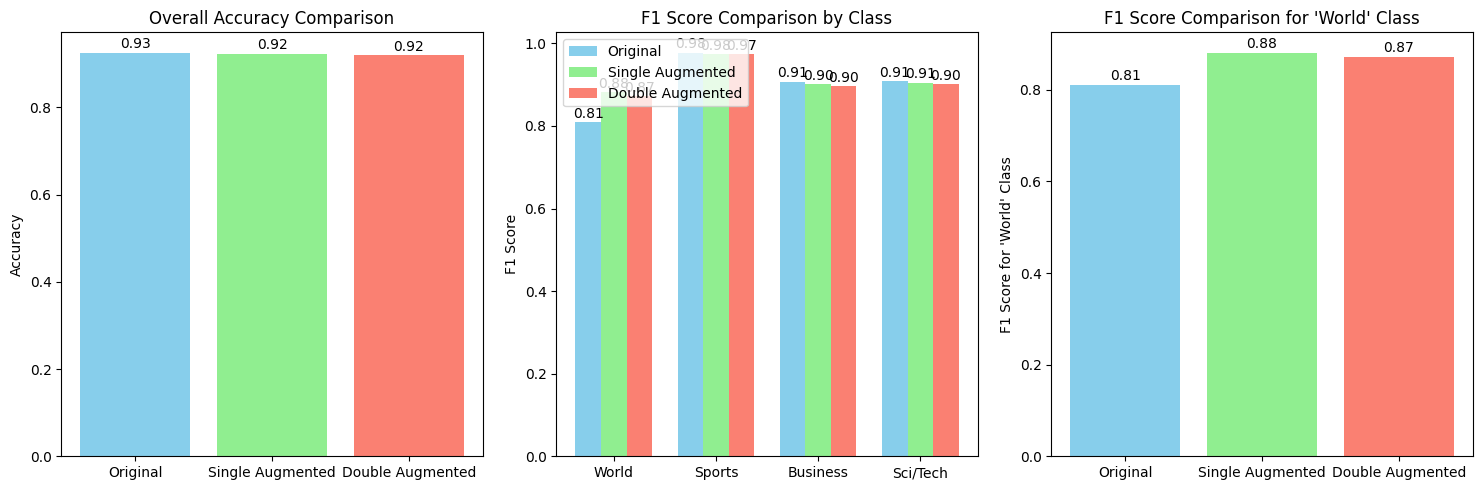

In [ ]:
# Download WordNet data for synonyms
nltk.download('wordnet')

# Load the dataset function
def load_news_dataset(file_path):
    data = pd.read_csv(file_path)
    print("Original Imbalanced Dataset Sample:")
    print(data.head())
    return data

# Synonym replacement function
def get_synonyms(word):
    synonyms = set()
    for syn in wn.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

def synonym_replacement(sentence, n=1):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if get_synonyms(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0

    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break

    return ' '.join(new_words)

# Load original imbalanced dataset
file_path = '/content/drive/Shareddrives/682_Drive/682-Project/ag_news_imbalanced.csv'
dataset = load_news_dataset(file_path)

# Step 1: Original Model Evaluation
X_original = dataset['text']
y_original = dataset['label']
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_original, y_original, test_size=0.3, random_state=42)

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer()
X_train_orig_tfidf = vectorizer.fit_transform(X_train_orig)
X_test_orig_tfidf = vectorizer.transform(X_test_orig)

# Train a logistic regression classifier on original dataset
model_orig = LogisticRegression(max_iter=1000, random_state=42)
model_orig.fit(X_train_orig_tfidf, y_train_orig)

# Evaluate model on original dataset
y_pred_orig = model_orig.predict(X_test_orig_tfidf)
original_accuracy = accuracy_score(y_test_orig, y_pred_orig)
original_f1_scores = f1_score(y_test_orig, y_pred_orig, average=None)

# Print results for original dataset
print("\nOriginal Model Performance:")
print("Accuracy:", original_accuracy)
print("F1 Scores by Class:", original_f1_scores)

# Step 2: Single Augmentation (only augment "World" class)
world_data = dataset[dataset['label'] == 0].copy()
world_data['text'] = world_data['text'].apply(lambda x: synonym_replacement(x, n=2))
single_augmented_dataset = pd.concat([dataset, world_data])

# Prepare single augmented dataset for training
X_single_aug = single_augmented_dataset['text']
y_single_aug = single_augmented_dataset['label']
X_train_aug_single, X_test_aug_single, y_train_aug_single, y_test_aug_single = train_test_split(X_single_aug, y_single_aug, test_size=0.3, random_state=42)

# Convert single augmented text to TF-IDF features
X_train_single_aug_tfidf = vectorizer.fit_transform(X_train_aug_single)
X_test_single_aug_tfidf = vectorizer.transform(X_test_aug_single)

# Train logistic regression on single augmented dataset
model_aug_single = LogisticRegression(max_iter=1000, random_state=42)
model_aug_single.fit(X_train_single_aug_tfidf, y_train_aug_single)

# Evaluate model on single augmented dataset
y_pred_aug_single = model_aug_single.predict(X_test_single_aug_tfidf)
single_augmented_accuracy = accuracy_score(y_test_aug_single, y_pred_aug_single)
single_augmented_f1_scores = f1_score(y_test_aug_single, y_pred_aug_single, average=None)

# Print results for single augmented dataset
print("\nSingle Augmentation Model Performance:")
print("Accuracy:", single_augmented_accuracy)
print("F1 Scores by Class:", single_augmented_f1_scores)

# Step 3: Double Augmentation (augment all classes)
augmented_dataset = single_augmented_dataset.copy()
augmented_dataset['text'] = augmented_dataset['text'].apply(lambda x: synonym_replacement(x, n=2))

# Prepare double augmented dataset for training
X_double_aug = augmented_dataset['text']
y_double_aug = augmented_dataset['label']
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_double_aug, y_double_aug, test_size=0.3, random_state=42)

# Convert double augmented text to TF-IDF features
X_train_double_aug_tfidf = vectorizer.fit_transform(X_train_aug)
X_test_double_aug_tfidf = vectorizer.transform(X_test_aug)

# Train logistic regression on double augmented dataset
model_aug_double = LogisticRegression(max_iter=1000, random_state=42)
model_aug_double.fit(X_train_double_aug_tfidf, y_train_aug)

# Evaluate model on double augmented dataset
y_pred_aug = model_aug_double.predict(X_test_double_aug_tfidf)
double_augmented_accuracy = accuracy_score(y_test_aug, y_pred_aug)
double_augmented_f1_scores = f1_score(y_test_aug, y_pred_aug, average=None)

# Print results for double augmented dataset
print("\nDouble Augmentation Model Performance:")
print("Accuracy:", double_augmented_accuracy)
print("F1 Scores by Class:", double_augmented_f1_scores)

# Plotting results
class_labels = ['World', 'Sports', 'Business', 'Sci/Tech']
x = np.arange(len(class_labels))
width = 0.25

plt.figure(figsize=(15, 5))

# Overall Accuracy Comparison
plt.subplot(1, 3, 1)
plt.bar(['Original', 'Single Augmented', 'Double Augmented'], [original_accuracy, single_augmented_accuracy, double_augmented_accuracy], color=['skyblue', 'lightgreen', 'salmon'])
plt.ylabel("Accuracy")
plt.title("Overall Accuracy Comparison")
for i, v in enumerate([original_accuracy, single_augmented_accuracy, double_augmented_accuracy]):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')

# Class-wise F1 Score Comparison
plt.subplot(1, 3, 2)
plt.bar(x - width, original_f1_scores, width, label='Original', color='skyblue')
plt.bar(x, single_augmented_f1_scores, width, label='Single Augmented', color='lightgreen')
plt.bar(x + width, double_augmented_f1_scores, width, label='Double Augmented', color='salmon')
plt.xticks(ticks=x, labels=class_labels)
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison by Class")
plt.legend()
for i in range(len(class_labels)):
    plt.text(i - width, original_f1_scores[i] + 0.01, f"{original_f1_scores[i]:.2f}", ha='center')
    plt.text(i, single_augmented_f1_scores[i] + 0.01, f"{single_augmented_f1_scores[i]:.2f}", ha='center')
    plt.text(i + width, double_augmented_f1_scores[i] + 0.01, f"{double_augmented_f1_scores[i]:.2f}", ha='center')

# F1 Score for "World" Class across Stages
plt.subplot(1, 3, 3)
plt.bar(['Original', 'Single Augmented', 'Double Augmented'], [original_f1_scores[0], single_augmented_f1_scores[0], double_augmented_f1_scores[0]], color=['skyblue', 'lightgreen', 'salmon'])
plt.ylabel("F1 Score for 'World' Class")
plt.title("F1 Score Comparison for 'World' Class")
for i, v in enumerate([original_f1_scores[0], single_augmented_f1_scores[0], double_augmented_f1_scores[0]]):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.show()
